## Gold Algorithm   

This algorithm was created using Zipline to backtest strategies

In [1]:
%load_ext zipline

In [2]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz
from zipline.api import order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target
from trading_calendars import get_calendar
import zipline
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime
import pandas_datareader.data as web
import datetime as dt
from zipline.finance.slippage import FixedSlippage
from zipline.algorithm import TradingAlgorithm
from zipline.finance import commission
from zipline.pipeline.factors import RSI
import talib

The function below ensures that the algorithm is not fed any missing values

In [3]:
#since there is missing data for some months, this is used to do a backwards fill for data called
def get_indicator_val(indicator, date):
    val = 0
    count = 0
    while True:
        try:
            #try to get a value from previous month if entry is missing
            date = date - dt.timedelta(days=count*30)
            #1st of every month
            date = datetime(date.year, date.month, 1)
            val = df_indicators[indicator][date]
            break
        except:
            pass
        count +=1
    return val

In [4]:
#make a date time variable and a context.i variable so that df[cci][i] can be referenced in handle_data
start = dt.datetime(2005,1,1)
end = dt.datetime(2018,1,1)
#import dataframe from GoldAnalysis so fedfunds rate can be used 
df_indicators = pd.read_csv('data/indicators.csv', index_col='DATE', parse_dates=True)

In [5]:
def initialize(context):
    set_benchmark(symbol("GLD"))
    context.i = 0
    context.set_slippage(FixedSlippage())
    context.set_commission(commission.PerTrade(cost=1))

    #set variables
    context.LOW_RSI = 30
    context.HIGH_RSI = 70
    context.window = 50
    buy_pct = 0

The logic of the algorithm is in the handle_data function below. Currently, it will:
* Buy when the relative strength index is below 30
* Buy when the one-week moving average is greater than the two-week moving average
* Buy when the derivative of the federal funds rate is positive
* Sell when the price of gold is less than its one week average

In [6]:
def handle_data(context, data):
    context.i += 1
    buy_pct = 0.0
    day_count = start + dt.timedelta(days=context.i)
    
    if context.i < context.window:
        return
    
    #relative strength index
    prices = data.history(symbol("GLD"), fields='price', bar_count=50, frequency='1d') #standard frame is 15
    rsi = talib.RSI(prices)
        
    if rsi[-1] < context.LOW_RSI: 
        # RSI under 30 indicates oversold
        buy_pct += .5
        pass



    elif rsi[-1] > context.HIGH_RSI:
        # RSI over 70 indicates overbought
        pass


    #moving average crossover
    slowma = data.history(symbol("GLD"), fields='price', bar_count=14, frequency='1d').mean()
    fastma = data.history(symbol("GLD"), fields='price', bar_count=7, frequency='1d').mean()

    if fastma > slowma:
        buy_pct += .75
    
    if fastma < slowma:
        pass

    #federal funds rate
    if get_indicator_val('FFR_dy/dt', day_count) > 0:
        buy_pct += 1
        pass
    
    
    if buy_pct != 0:
        order_target_percent(symbol("GLD"), buy_pct)
        
    if data.current(symbol('GLD'), fields='price') < data.history(symbol("GLD"), fields='price', bar_count=7, frequency='1d').mean():
        order_target_percent(symbol("GLD"), -0.25)
    

    record(GLD=data.current(symbol('GLD'), fields='price'))

Local csv file of GLD, a gold ETF, is put into a format that the algorithm can handle.
The price of gold is not used here because I could not find any free data that had the correct OHLCV format that Zipline needs to backtest. This gold ETF is highly correlated with the price of gold so it will work for now.

In [7]:
data = OrderedDict()
data['GLD'] = pd.read_csv("data/GLD.csv")
data['GLD'].set_index('date', inplace=True)
data['GLD'].drop('adj close', axis=1, inplace=True)

data['GLD'].index = pd.to_datetime(data['GLD'].index, infer_datetime_format=True)
data['GLD'] = data['GLD'].resample("D").mean()
data['GLD'].fillna(method="ffill", inplace=True)

data['GLD'] = data['GLD'][["open","high","low","close","volume"]]
#data['GLD']['date'] = data['GLD']['date'].tz_localize(pytz.utc)
print(data['GLD'].head())
panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

                 open       high        low      close      volume
date                                                              
2004-11-18  44.430000  44.490002  44.070000  44.380001   5992000.0
2004-11-19  44.490002  44.919998  44.470001  44.779999  11655300.0
2004-11-20  44.490002  44.919998  44.470001  44.779999  11655300.0
2004-11-21  44.490002  44.919998  44.470001  44.779999  11655300.0
2004-11-22  44.750000  44.970001  44.740002  44.950001  11996000.0
<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 5160 (major_axis) x 5 (minor_axis)
Items axis: GLD to GLD
Major_axis axis: 2004-11-18 00:00:00+00:00 to 2019-01-03 00:00:00+00:00
Minor_axis axis: open to volume


In [10]:
#evaluate performance 
perf = zipline.run_algorithm(start=datetime(start.year, start.month, start.day, 0, 0, 0, 0, pytz.utc),
                        end=datetime(end.year, end.month, end.day, 0, 0, 0, 0, pytz.utc),
                        initialize=initialize,
                        capital_base=10000,
                        handle_data=handle_data,
                        data_frequency ='daily',
                        data=panel)

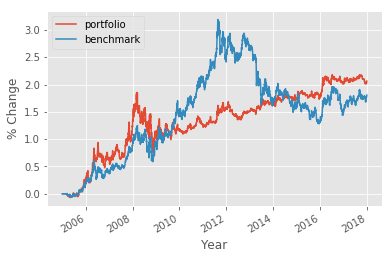

In [11]:
#plot results
style.use("ggplot")

perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.GLD.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark')
plt.xlabel("Year")
plt.ylabel("% Change")
plt.legend(loc=2)


plt.show()

This algorithm outperforms gold, but not by much.

In [12]:
print(perf['alpha'].mean())

0.030123276838355032


In [13]:
print(perf['beta'].mean())

0.7884323658581802


In [14]:
print(perf['algorithm_period_return'][-1]-perf['benchmark_period_return'][-1])

0.23871322916937565


## Conclusion

---

This is a rudementary version of the algorithm I would like to create. With low trading fees considered and some margin used, this algorithm beats the return of gold by 0.23% with a more consistent rate of return. However, it has a relatively low alpha and a high beta, so there is certainly room for improvement. That being said, it has not been optimized and it only uses three very simple indicators to trade with. 

Despite this, it still shows evidence that trading gold by using the FFR as an indicator will increase its profitabliltiy. Below is an image of the portfolio performance when the FFR is not used.

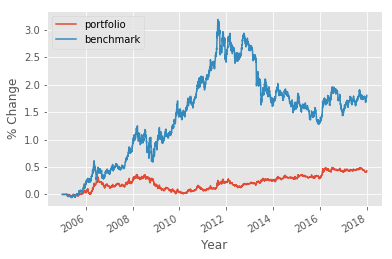

In [15]:
from IPython.display import Image

fig = Image(filename=('data/no_ffr_perf.png'))
fig